In [1]:
import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
BATCH_SIZE = 128
NUM_WORKERS = 3
MULT = 2
device = "cuda" if torch.cuda.is_available() else "cpu" 

print("Training on {}".format(device))

Training on cuda


In [3]:
torch_utils.seed_everything(43)

In [4]:
class MyData(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
        if y is not None:
            assert len(y)==len(X)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = np.array(self.X[idx,:], dtype='uint8').reshape(28,28)
        if self.transforms is not None:
            img = self.transforms(img)
        
        if self.y is not None:
            return img, self.y[idx]
        return img

In [5]:
train_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.RandomRotation(10),
    txf.RandomAffine(degrees=7, translate=(0.3,0.3), scale=(0.8, 1.2), shear=7,),
    txf.ToTensor()
])

test_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.FiveCrop(20),
    txf.Lambda(lambda crops: [txf.Resize(28)(crop) for crop in crops]),
    txf.Lambda(lambda crops: torch.stack([txf.ToTensor()(crop) for crop in crops]))
])

In [6]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
dig_df = pd.read_csv("./Dig-MNIST.csv")
sub_df = pd.read_csv("./sample_submission.csv")

In [7]:
target = train_df["label"]
train_df.drop("label", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, stratify=target, random_state=947, test_size=0.1)

In [9]:
len(X_train), len(X_valid)

(54000, 6000)

In [10]:
dataset_train = MyData(train_df.to_numpy(), target.to_numpy(), train_transforms)
dataset_valid = MyData(X_valid.to_numpy(), y_valid.to_numpy(), test_transforms)
dataset_test = MyData(test_df.to_numpy(), transforms=test_transforms)
dataset_dig = MyData(dig_df.drop("label", axis=1).to_numpy(), dig_df["label"].to_numpy(), test_transforms)

In [11]:
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
dig_loader = DataLoader(dataset_dig, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

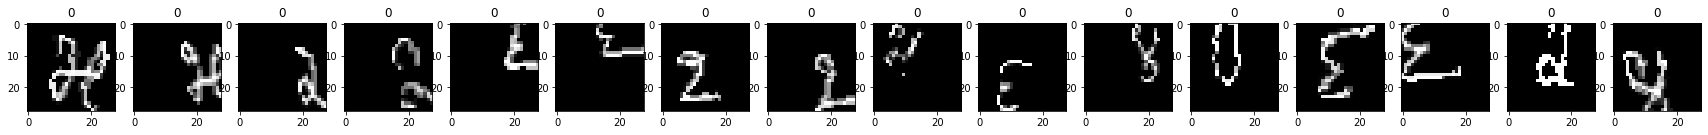

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(batch[1][i].data.numpy().argmax())
        ax[i].imshow(batch[0][i, 0], cmap="gray")
    break

In [13]:
class SQENet(nn.Module):
    def __init__(self, n_classes, drop_prob=0.3):
        super(SQENet, self).__init__()
        
        self.conv1 = torch_utils.CNNLayer(1, MULT*32)
        self.conv2 = torch_utils.CNNLayer(MULT*32, MULT*32)
        
        self.conv3 = torch_utils.CNNLayer(MULT*32, MULT*64)
        self.conv4 = torch_utils.CNNLayer(MULT*64, MULT*64)
        
        self.conv5 = torch_utils.CNNLayer(MULT*64, MULT*128)
        self.conv6 = torch_utils.CNNLayer(MULT*128, MULT*128)
        
        self.se3 = torch_utils.Sq_Ex_Block(in_ch=256,r=8)
        
        self.fc1 = torch_utils.FCLayer(MULT*128*3*3, 256)
        self.fc2 = torch_utils.FCLayer(256, n_classes)
        
        
        self.maxpool = nn.MaxPool2d(2, 2) 
        self.drop = nn.Dropout2d(p=drop_prob)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.drop(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = self.se3(x)
        
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [14]:
model = SQENet(10)
criterion = torch_utils.LabelSmoothingLoss(10, smoothing=0.15)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True, patience=5)
EPOCHS = 90

In [15]:
# import time
# history = pd.DataFrame()
# for epoch in range(EPOCHS):
#     curt = time.time()
#     torch_utils.clear_cuda()
#     print("Current Learning Rate: {}".format(torch_utils.get_lr(optimizer)))
    
#     tr_loss, tr_acc = torch_utils.train_classifier(model, optimizer, criterion, epoch+1, train_loader, device=device,print_interval=100)
#     vl_loss, vl_acc = torch_utils.test_classifier(model, criterion, device, dig_loader, tta=True)
    
#     scheduler.step(vl_loss)
#     print("Val Loss: {}  Time Taken: {}\n".format(vl_loss, time.time()-curt))
    
#     history.loc[epoch, "train_loss"] = tr_loss
#     history.loc[epoch, "valid_loss"] = vl_loss
#     history.loc[epoch, "train_accuracy"] = tr_acc
#     history.loc[epoch, "valid_accuracy"] = vl_acc

In [16]:
# history["train_loss"].plot()

In [17]:
# history["train_accuracy"].plot()

In [18]:
# history["valid_loss"].plot()

In [19]:
# history["valid_accuracy"].plot()

In [20]:
# preds = []
# for x in test_loader:
#     y_pred = model(x.to(device))
#     y_pred = y_pred.argmax(dim=1)
#     preds.extend(y_pred.cpu().numpy())
# sub_df["label"] = pd.Series(preds)

In [21]:
# sub_df.to_csv("submission.csv", index=False)

In [22]:
# torch.save(model.state_dict(), "SENet_90.pt")

In [24]:
def pseudo_train(model, optimizer, criterion, current_epoch, train_loader, test_loader, alpha, device="cpu", print_interval=10):
    model.train()
    model.to(device)
    
    p_correct = 0
    p_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(test_loader):
        
        len_data = len(data)
        len_dataset = len(test_loader.dataset)
        len_loader = len(test_loader)
        
        
        # pseudo labeling
        model.eval()
        y_pred = model(data)
        y_pred = y_pred.argmax(dim=1)
        target = torch.LongTensor(y_pred, requires_grad=True)
        model.train()
        
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        p_correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        p_loss+= (loss.item() * len_data)
        loss.backward()
        optimizer.step()
        
        if batch_idx%100==0:
            for b, (d, t) in train_loader:
                d, t = d.to(device), t.to(device)
                optimizer.zero_grad()
                o = model(d)
                l = criterion(o, t)
                l.backward()
                optimizer.step()
        
        if batch_idx % print_interval == 0:
            print(
                'Pseudo Train Epoch: {} [{}/{} ({:.8f}%)]\tLoss: {:.8f}'.format(
                    current_epoch, batch_idx * len_data, len_dataset,100. * batch_idx / len_loader, loss.item()
                    )
                )
    ## This is training, so reduction = mean, i.e. loss.item() already gives the mean of the batch
    p_loss/=len_dataset
    p_accuracy = 100. * p_correct / len_dataset
    print('Train Set: Average loss: {:.8f}, Accuracy: {}/{} ({:.8f}%)'.format(
        p_loss, p_correct, len_dataset, p_accuracy
        )
    )
    
    return p_loss, p_accuracy